This code needs to be cleaned.

In [ ]:
import gzip
import gensim
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
!pip install fasttext
!pip install gdown

In [ ]:
%ls

In [ ]:
import numpy as np
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import os

In [ ]:
!wget "http://nlp.stanford.edu/data/glove.6B.zip"

In [ ]:
%ls

In [ ]:
import zipfile
with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
  zip_ref.extract('glove.6B.300d.txt')

In [ ]:
%ls



```
# This is ignored code
"""
def download_glove_embeddings():
    """
    #Download GloVe embeddings if not already present.
    """
    if not os.path.exists('glove.6B.300d.txt'):
        print("Downloading GloVe embeddings...")
        import urllib.request
        url = "http://nlp.stanford.edu/data/glove.6B.zip"
        filename = "glove.6B.zip"
        urllib.request.urlretrieve(url, filename)

        import zipfile
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extract('glove.6B.300d.txt')

        os.remove(filename)
        print("Download complete.")
"""
```



In [ ]:
def load_glove_embeddings():
    #Load GloVe embeddings and return as a dictionary.
    #Convert GloVe file to Word2Vec format
  glove_file = 'glove.6B.300d.txt'
  word2vec_glove_file = 'glove.6B.300d.word2vec.txt'
  glove2word2vec(glove_file, word2vec_glove_file)

    # Load the converted file
  model = KeyedVectors.load_word2vec_format(word2vec_glove_file, binary=False)

    # Create a dictionary to store the word embeddings
  word_embeddings = {}

    # Populate the dictionary with word embeddings
  for word in model.key_to_index:
    word_embeddings[word] = model[word]

  return word_embeddings

# Load the embeddings
word_embeddings_glove = load_glove_embeddings()

In [ ]:
print(f"Number of words: {len(word_embeddings_glove)}")
print(f"Embedding dimension: {len(next(iter(word_embeddings_glove.values())))}")

In [ ]:
'''import fasttext
import fasttext.util

# Download the English FastText model
fasttext.util.download_model('en', if_exists='ignore')

# Load the pre-trained model
model = fasttext.load_model('cc.en.300.bin')

# Create a dictionary of word embeddings
word_embeddings = {}

# Get all words in the vocabulary
words = model.get_words()

for word in words:
    word_embeddings[word] = model.get_word_vector(word)

print(f"Total number of words: {len(word_embeddings)}")
print(f"Dimension of each word vector: {len(next(iter(word_embeddings.values())))}")

# Example: Print the first 5 words and their vector dimensions
for word in list(word_embeddings.keys())[:5]:
    print(f"{word}: {word_embeddings[word].shape}")'''

In [ ]:
import gensim.downloader as api

# Load pre-trained Word2Vec model
model = api.load('word2vec-google-news-300')

all_words = list(model.key_to_index.keys())

word_embeddings_w2v = {}
for word in model.key_to_index:
    word_embeddings_w2v[word] = model[word]

print(f"Total number of words: {len(all_words)}")
print(f"Dimension of each word vector: {len(word_embeddings_w2v[all_words[0]])}")

In [ ]:
print(len(word_embeddings_w2v.keys()))

In [ ]:
import random

def pick_random_pairs(dictionary, num_pairs,seed):
    random.seed(seed)
    keys = list(dictionary.keys())
    random.shuffle(keys)
    random_pairs = {}
    for key in keys[:num_pairs]:
        random_pairs[key] = dictionary[key]
    return random_pairs

random_embeddings = pick_random_pairs(word_embeddings_glove,400000,7)

# we don't have to randomize if we are using all embeddings, but for the sake of using the same code we let it go here

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize

def normalize_word_embeddings(embeddings):
    # Extract the word vectors and store them in a numpy array
    embeddings_values = np.array(list(embeddings.values()))

    # Normalize the word embeddings
    normalized_embeddings = normalize(embeddings_values)

    # Update the normalized embeddings back in the dictionary
    for i, word in enumerate(embeddings.keys()):
        embeddings[word] = normalized_embeddings[i]

    return embeddings

In [ ]:
# Call the function to get normalized word embeddings
#normalized_embeddings = normalize_word_embeddings(word_embeddings)
random_normalized_embeddings = normalize_word_embeddings(random_embeddings)
#print(normalized_embeddings)

In [ ]:
len(random_normalized_embeddings.keys())

In [ ]:
!pip install faiss-gpu

In [ ]:
#Using spheres
#This code can be run.

import numpy as np
import faiss
import matplotlib.pyplot as plt

def correlation_dimension_faiss(data, max_radius, num_radii=20,k=100):
    """
    Calculate the correlation dimension of the dataset using Faiss.

    :param data: numpy array of shape (n_samples, n_features)
    :param max_radius: maximum radius for correlation sum calculation
    :param num_radii: number of radii to use for calculation
    :return: radii, correlation_sum
    """
    n_samples, n_features = data.shape

    # Convert data to float32 (required by Faiss)
    data = data.astype(np.float32)

    # Create Faiss index
    index = faiss.IndexFlatL2(n_features)
    index.add(data)

    # Generate radii
    radii = np.logspace(-1, np.log10(max_radius), num_radii)

    # Calculate correlation sum for each radius
    correlation_sum = np.zeros(num_radii)
    for i, r in enumerate(radii):
        # Count number of neighbors within radius r for each point
        #print(index.range_search(data, r**2))
        #neighbors = index.range_search(data, r**2)  # Faiss uses squared distances
        #correlation_sum[i] = len(neighbors) / (n_samples * (n_samples - 1))

        distances, _ = index.search(data, k)

        # Count number of neighbors within radius r for each point
        count_within_radius = np.sum(distances < r**2, axis=1) - 1  # subtract 1 to exclude the point itself
        total_count = np.sum(count_within_radius)
        correlation_sum[i] = max(total_count / (n_samples * (n_samples - 1)), 1e-10)

    return radii, correlation_sum

def estimate_fractal_dimension(radii, correlation_sum):
    """
    Estimate fractal dimension from the slope of log-log plot.

    :param radii: array of radii used
    :param correlation_sum: array of correlation sums
    :return: estimated fractal dimension
    """
    log_radii = np.log(radii)
    log_correlation_sum = np.log(correlation_sum)

    print(log_radii,log_correlation_sum)
    # Linear regression to find slope
    coeffs = np.polyfit(log_radii, log_correlation_sum, deg=1)
    return coeffs[0]

In [ ]:
if __name__ == "__main__":

    n_samples, n_features = len(random_normalized_embeddings), len(list(random_normalized_embeddings.values())[0])
    embeddings_list = list(random_normalized_embeddings.values())

    # Convert to a NumPy array with dtype float32
    word_embeddings_fractal = np.array(embeddings_list, dtype=np.float32)

    # Calculate correlation dimension
    max_radius = np.sqrt(n_features)  # Maximum possible distance in the feature space
    radii, correlation_sum = correlation_dimension_faiss(word_embeddings_fractal, max_radius)

    # Estimate fractal dimension
    fractal_dim = estimate_fractal_dimension(radii, correlation_sum)

    print(f"Estimated fractal dimension: {fractal_dim:.2f}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.loglog(radii, correlation_sum, 'bo-')
    plt.xlabel('Radius (r)')
    plt.ylabel('Correlation Sum C(r)')
    plt.title('Correlation Dimension Analysis')
    plt.grid(True)
    plt.show()

    #Word2vec google news - hugging face 3M words embeddings,Russian National corpus,, fasttext embeddings.
    #Complete works of shakesphere, word to word path connection, Projection wise fractal dimension calculation
    #Understand brazillians code.



```
# This is formatted as code
**KeyboardInterrupt**                         Traceback (most recent call last)
<ipython-input-26-e11b30dddfd9> in <cell line: 1>()
      9     # Calculate correlation dimension
     10     max_radius = np.sqrt(n_features)  # Maximum possible distance in the feature space
---> 11     radii, correlation_sum = correlation_dimension_faiss(word_embeddings_fractal, max_radius)
     12
     13     # Estimate fractal dimension

2 frames
/usr/local/lib/python3.10/dist-packages/faiss/swigfaiss.py in search(self, n, x, k, distances, labels)
   2144
   2145     def search(self, n, x, k, distances, labels):
-> 2146         return _swigfaiss.IndexFlat_search(self, n, x, k, distances, labels)
   2147
   2148     def range_search(self, n, x, radius, result):

**KeyboardInterrupt**:
```



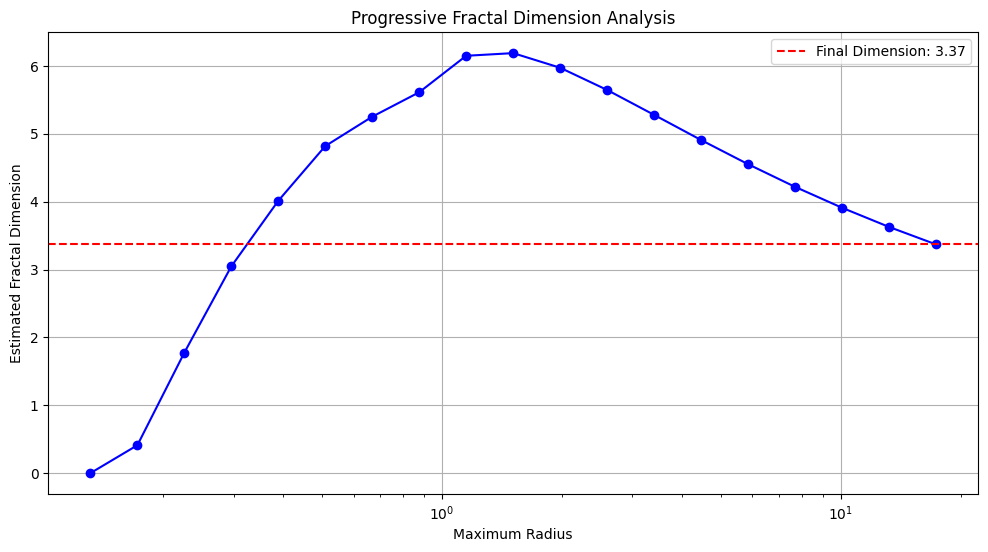

Final estimated fractal dimension: 3.37
Up to radius 0.1312: Estimated dimension = 0.00
Up to radius 0.1720: Estimated dimension = 0.41
Up to radius 0.2257: Estimated dimension = 1.78
Up to radius 0.2960: Estimated dimension = 3.05
Up to radius 0.3882: Estimated dimension = 4.01
Up to radius 0.5092: Estimated dimension = 4.82
Up to radius 0.6679: Estimated dimension = 5.25
Up to radius 0.8761: Estimated dimension = 5.61
Up to radius 1.1491: Estimated dimension = 6.15
Up to radius 1.5073: Estimated dimension = 6.19
Up to radius 1.9770: Estimated dimension = 5.97
Up to radius 2.5932: Estimated dimension = 5.65
Up to radius 3.4013: Estimated dimension = 5.28
Up to radius 4.4613: Estimated dimension = 4.91
Up to radius 5.8517: Estimated dimension = 4.55
Up to radius 7.6754: Estimated dimension = 4.22
Up to radius 10.0675: Estimated dimension = 3.91
Up to radius 13.2051: Estimated dimension = 3.63
Up to radius 17.3205: Estimated dimension = 3.37


In [ ]:
#Track progressive fractal dimension value, that is if I stop at 10^0 what is the fractal dimension before that?

import numpy as np
import faiss
import matplotlib.pyplot as plt

def correlation_dimension_faiss(data, max_radius, num_radii=20, k=100):
    n_samples, n_features = data.shape
    data = data.astype(np.float32)

    index = faiss.IndexFlatL2(n_features)
    index.add(data)

    radii = np.logspace(-1, np.log10(max_radius), num_radii)
    correlation_sum = np.zeros(num_radii)

    distances, _ = index.search(data, k)

    for i, r in enumerate(radii):
        count_within_radius = np.sum(distances < r, axis=1) - 1
        total_count = np.sum(count_within_radius)
        correlation_sum[i] = max(total_count / (n_samples * (n_samples - 1)), 1e-10)

    return radii, correlation_sum

def estimate_fractal_dimension(radii, correlation_sum):
    valid_indices = correlation_sum > 0
    log_radii = np.log(radii[valid_indices])
    log_correlation_sum = np.log(correlation_sum[valid_indices])

    if len(log_radii) < 2:
        return np.nan

    coeffs = np.polyfit(log_radii, log_correlation_sum, deg=1)
    return coeffs[0]

def progressive_fractal_dimension(data, max_radius, num_radii=20, k=100):
    radii, correlation_sum = correlation_dimension_faiss(data, max_radius, num_radii, k)
    progressive_dimensions = []

    for i in range(2, len(radii) + 1):
        dim = estimate_fractal_dimension(radii[:i], correlation_sum[:i])
        progressive_dimensions.append(dim)

    return radii[1:], progressive_dimensions

# Example usage
if __name__ == "__main__":

    n_samples, n_features = len(random_normalized_embeddings), len(list(random_normalized_embeddings.values())[0])
    embeddings_list = list(random_normalized_embeddings.values())

    word_embeddings_fractal = np.array(embeddings_list, dtype=np.float32)

    max_radius = np.sqrt(n_features)
    radii, progressive_dims = progressive_fractal_dimension(word_embeddings_fractal, max_radius)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(radii, progressive_dims, 'bo-')
    plt.xscale('log')
    plt.xlabel('Maximum Radius')
    plt.ylabel('Estimated Fractal Dimension')
    plt.title('Progressive Fractal Dimension Analysis')
    plt.grid(True)

    # Add final estimated dimension to the plot
    final_dim = progressive_dims[-1]
    plt.axhline(y=final_dim, color='r', linestyle='--', label=f'Final Dimension: {final_dim:.2f}')
    plt.legend()

    plt.show()

    print(f"Final estimated fractal dimension: {final_dim:.2f}")

    # Print progressive dimensions
    for i, (r, dim) in enumerate(zip(radii, progressive_dims)):
        print(f"Up to radius {r:.4f}: Estimated dimension = {dim:.2f}")

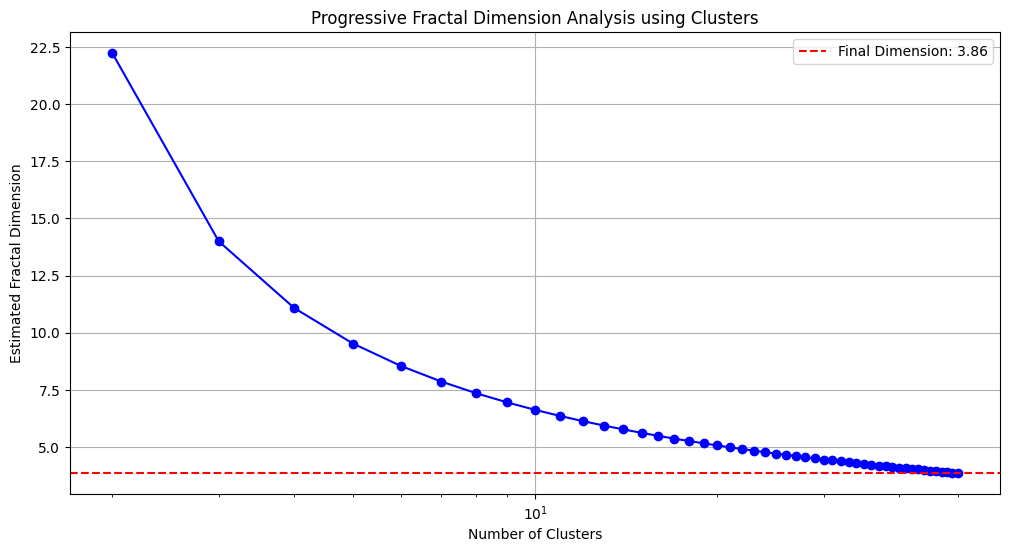


Number of clusters: 2
Cluster sizes: [269415 130585]
Cluster fractal dimensions: [18.03947065 16.99462966]
Total fractal dimension: 22.2264

Number of clusters: 3
Cluster sizes: [166415  57140 176445]
Cluster fractal dimensions: [10.94311439  9.97008662 10.99638573]
Total fractal dimension: 13.9953

Number of clusters: 4
Cluster sizes: [139147  20565 112340 127948]
Cluster fractal dimensions: [8.54312514 7.16395173 8.38875609 8.48259904]
Total fractal dimension: 11.0764

Number of clusters: 5
Cluster sizes: [136158  54987  87624  98392  22839]
Cluster fractal dimensions: [7.3451552  6.7817789  7.07129497 7.14331052 6.23585713]
Total fractal dimension: 9.5278

Number of clusters: 6
Cluster sizes: [104598  19244  54881  49341  58021 113915]
Cluster fractal dimensions: [6.45057549 5.50573599 6.090618   6.03122843 6.12167006 6.49819802]
Total fractal dimension: 8.5492

Number of clusters: 7
Cluster sizes: [ 56394  54770 118385  18130  60206  67521  24594]
Cluster fractal dimensions: [5.62

In [ ]:
import numpy as np
import faiss
import matplotlib.pyplot as plt

def cluster_fractal_analysis(data, max_clusters, min_clusters=2):
    #1st row - cluster_sizes
    #2nd row - fractal dimension of each box/cluster
    #3rd row - average.
    n_samples, n_features = data.shape
    data = data.astype(np.float32)

    results = []

    for k in range(min_clusters, max_clusters + 1):
        kmeans = faiss.Kmeans(d=n_features, k=k, niter=300, verbose=False)
        kmeans.train(data)
        _, labels = kmeans.index.search(data, 1)

        # Calculate cluster sizes
        unique, counts = np.unique(labels, return_counts=True)
        cluster_sizes = counts[counts > 0]

        # Calculate fractal dimension for each cluster
        cluster_fractal_dims = np.log(cluster_sizes) / np.log(k)

        # Calculate total fractal dimension
        log_n = np.log(k)
        log_m = np.log(np.sum(cluster_sizes * np.log(cluster_sizes)))
        total_dimension = log_m / log_n if log_n != 0 else np.nan

        # Store results
        results.append({
            'num_clusters': k,
            'cluster_sizes': cluster_sizes,
            'cluster_fractal_dims': cluster_fractal_dims,
            'total_fractal_dim': total_dimension
        })

    return results

def cluster_fractal_dimension(data, max_clusters, min_clusters=2):
    n_samples, n_features = data.shape
    data = data.astype(np.float32)

    dimensions = []
    cluster_counts = range(min_clusters, max_clusters + 1)

    for k in cluster_counts:
        kmeans = faiss.Kmeans(d=n_features, k=k, niter=300, verbose=False)
        kmeans.train(data)
        _, labels = kmeans.index.search(data, 1)

        # Calculate cluster sizes
        unique, counts = np.unique(labels, return_counts=True)
        cluster_sizes = counts[counts > 0]

        # Calculate fractal dimension using box-counting method
        log_n = np.log(k)
        log_m = np.log(np.sum(cluster_sizes * np.log(cluster_sizes)))
        dimension = log_m / log_n if log_n != 0 else np.nan

        dimensions.append(dimension)

    return cluster_counts, dimensions

def progressive_fractal_dimension(data, max_clusters, min_clusters=2):
    cluster_counts, dimensions = cluster_fractal_dimension(data, max_clusters, min_clusters)
    return cluster_counts, dimensions

# Example usage
if __name__ == "__main__":
    # Assuming random_normalized_embeddings is your dictionary of word embeddings
    n_samples = len(random_normalized_embeddings)
    n_features = len(list(random_normalized_embeddings.values())[0])
    embeddings_list = list(random_normalized_embeddings.values())

    word_embeddings_fractal = np.array(embeddings_list, dtype=np.float32)

    max_clusters = min(50, n_samples // 2)  # Adjust based on your data size
    cluster_counts, progressive_dims = progressive_fractal_dimension(word_embeddings_fractal, max_clusters)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_counts, progressive_dims, 'bo-')
    plt.xscale('log')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Estimated Fractal Dimension')
    plt.title('Progressive Fractal Dimension Analysis using Clusters')
    plt.grid(True)

    # Add final estimated dimension to the plot
    final_dim = progressive_dims[-1]
    plt.axhline(y=final_dim, color='r', linestyle='--', label=f'Final Dimension: {final_dim:.2f}')
    plt.legend()

    plt.show()


    results = cluster_fractal_analysis(word_embeddings_fractal, max_clusters)

    # Print results
    for result in results:
        print(f"\nNumber of clusters: {result['num_clusters']}")
        print("Cluster sizes:", result['cluster_sizes'])
        print("Cluster fractal dimensions:", result['cluster_fractal_dims'])
        print(f"Total fractal dimension: {result['total_fractal_dim']:.4f}")